# **Hi there** ,

This Notebook will deal with an implementation of 
5 Layered CNN architecture
* **Resnet**
* **VGG16**
* **VGG19**
* **Imagnet**
* **Inception Model**

In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array

EPOCHS = 5
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((128,128))
image_size = 0
directory_root = '/kaggle/input/brain-tumor-mri-images-44c'
width=128
height=128
depth=3

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    root_dir = os.listdir(directory_root)
    
    for plant_folder in root_dir:
        plant_disease_folder_list = os.listdir(os.path.join(directory_root, plant_folder))

        for disease_folder in plant_disease_folder_list:
            disease_folder_path = os.path.join(directory_root, plant_folder, disease_folder)
            
            # Check if the path is a directory
            if os.path.isdir(disease_folder_path):
                # If it's a directory, process its contents
                plant_disease_image_list = os.listdir(disease_folder_path)
                for image in plant_disease_image_list[:200]:
                    image_directory = os.path.join(disease_folder_path, image)
                    if image_directory.endswith((".jpg", ".JPG", ".jpeg", ".JPEG")):
                        image_list.append(convert_image_to_array(image_directory))
                        label_list.append(plant_disease_folder)
            else:
                # If it's a file, process it directly
                image_directory = disease_folder_path
                if image_directory.endswith((".jpg", ".JPG", ".jpeg", ".JPEG")):
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_folder)
    
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error --- : {e}")


[INFO] Loading images ...
[INFO] Image loading completed


In [3]:
image_size = len(image_list)
image_size

4478

In [4]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Astrocitoma T1' 'Astrocitoma T1C+' 'Astrocitoma T2' 'Carcinoma T1'
 'Carcinoma T1C+' 'Carcinoma T2' 'Ependimoma T1' 'Ependimoma T1C+'
 'Ependimoma T2' 'Ganglioglioma T1' 'Ganglioglioma T1C+'
 'Ganglioglioma T2' 'Germinoma T1' 'Germinoma T1C+' 'Germinoma T2'
 'Glioblastoma T1' 'Glioblastoma T1C+' 'Glioblastoma T2' 'Granuloma T1'
 'Granuloma T1C+' 'Granuloma T2' 'Meduloblastoma T1' 'Meduloblastoma T1C+'
 'Meduloblastoma T2' 'Meningioma T1' 'Meningioma T1C+' 'Meningioma T2'
 'Neurocitoma T1' 'Neurocitoma T1C+' 'Neurocitoma T2'
 'Oligodendroglioma T1' 'Oligodendroglioma T1C+' 'Oligodendroglioma T2'
 'Papiloma T1' 'Papiloma T1C+' 'Papiloma T2' 'Schwannoma T1'
 'Schwannoma T1C+' 'Schwannoma T2' 'Tuberculoma T1' 'Tuberculoma T1C+'
 'Tuberculoma T2' '_NORMAL T1' '_NORMAL T2']


# **Normalization Of images**

In [5]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


# **Augmentation Of data**

In [6]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

# ***5 Layer CNN Algorithm ***

In [7]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 42, 42, 64)       

# **Optimizer**

In [8]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [9]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=5, verbose=1
    )

Epoch 1/5
111/111 [==============================] - 17s 150ms/step - loss: 0.1039 - accuracy: 0.9756 - val_loss: 0.2639 - val_accuracy: 0.9559
Epoch 2/5
111/111 [==============================] - 13s 117ms/step - loss: 0.0832 - accuracy: 0.9774 - val_loss: 0.2636 - val_accuracy: 0.9611
Epoch 3/5
111/111 [==============================] - 13s 115ms/step - loss: 0.0736 - accuracy: 0.9785 - val_loss: 0.2890 - val_accuracy: 0.9571
Epoch 4/5
111/111 [==============================] - 13s 115ms/step - loss: 0.0649 - accuracy: 0.9799 - val_loss: 0.1785 - val_accuracy: 0.9630
Epoch 5/5
111/111 [==============================] - 13s 114ms/step - loss: 0.0606 - accuracy: 0.9813 - val_loss: 0.0705 - val_accuracy: 0.9789


# **Results and Plots**

In [10]:
def Res_Plot_Test_Save(name):
    print("[INFO] Plotting model accuracy and Loss")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    #Train and validation accuracy
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    #Train and validation loss
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()
    
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")
    
    #print("[INFO] Saving model")
    #model.save(name)
    

[INFO] Plotting model accuracy and Loss


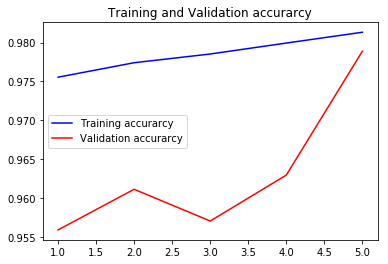

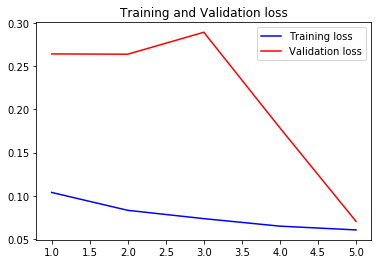

[INFO] Calculating model accuracy
896/896 [==============================] - 1s 590us/step
Test Accuracy: 97.88960814476013


In [11]:
Res_Plot_Test_Save('penta_CNN_Algorithm.h5')

# Transfer Learning Implementation

### Transfer Learning Advantages
Typically transfer learning enables us to build more robust models which can perform a wide variety of tasks.
* Helps solve complex real-world problems with several constraints
* Tackle problems like having little or almost no labeled data availability
* Ease of transfering knowledge from one model to another based on domains and tasks
* Provides a path towards achieving Artificial General Intelligence some day in the future!

**For References Check out**
[https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a]

### **Inception ModelV3**

##### Weights : Imagenet

In [12]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(128, 128, 3))
                             
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) 
model.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 63, 63, 32)   96          conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 63, 63, 32)   0           batch_normalization_7[0][0]      
___________________________

In [13]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/5
111/111 [==============================] - 19s 172ms/step - loss: 0.0973 - accuracy: 0.9772 - val_loss: 0.1578 - val_accuracy: 0.9656
Epoch 2/5
111/111 [==============================] - 14s 123ms/step - loss: 0.0829 - accuracy: 0.9776 - val_loss: 0.1756 - val_accuracy: 0.9661
Epoch 3/5
111/111 [==============================] - 14s 126ms/step - loss: 0.0780 - accuracy: 0.9780 - val_loss: 0.1546 - val_accuracy: 0.9668
Epoch 4/5
111/111 [==============================] - 14s 123ms/step - loss: 0.0742 - accuracy: 0.9784 - val_loss: 0.1860 - val_accuracy: 0.9650
Epoch 5/5
111/111 [==============================] - 14s 124ms/step - loss: 0.0727 - accuracy: 0.9786 - val_loss: 0.1829 - val_accuracy: 0.9654


[INFO] Plotting model accuracy and Loss


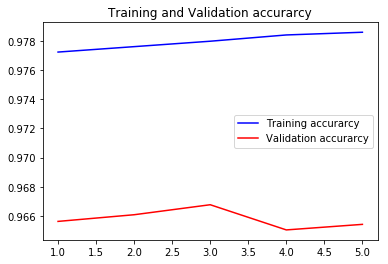

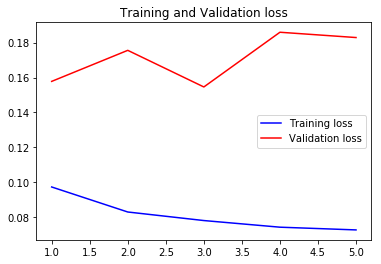

[INFO] Calculating model accuracy
896/896 [==============================] - 1s 1ms/step
Test Accuracy: 96.54272198677063


In [14]:
Res_Plot_Test_Save('Inception_ModelV3_(Imagenet_Weights).h5')

### **Resnet Model**

##### Weights : Imagenet

In [15]:
from keras.models import Model
from keras import applications
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the Resnet model so we can do transfer learning
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (128,128,3))
                             
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) 
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [16]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=5, verbose=1
    )

Epoch 1/5
111/111 [==============================] - 42s 376ms/step - loss: 0.1083 - accuracy: 0.9765 - val_loss: 0.3374 - val_accuracy: 0.9646
Epoch 2/5
111/111 [==============================] - 18s 167ms/step - loss: 0.0905 - accuracy: 0.9772 - val_loss: 0.1119 - val_accuracy: 0.9748
Epoch 3/5
111/111 [==============================] - 19s 168ms/step - loss: 0.0824 - accuracy: 0.9773 - val_loss: 0.1324 - val_accuracy: 0.9744
Epoch 4/5
111/111 [==============================] - 19s 168ms/step - loss: 0.0769 - accuracy: 0.9776 - val_loss: 0.3767 - val_accuracy: 0.9627
Epoch 5/5
111/111 [==============================] - 19s 167ms/step - loss: 0.0722 - accuracy: 0.9781 - val_loss: 0.1519 - val_accuracy: 0.9701


[INFO] Plotting model accuracy and Loss


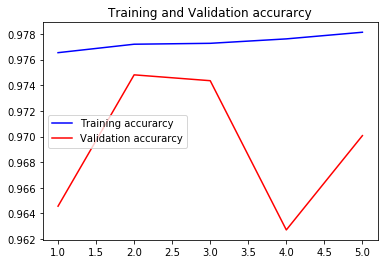

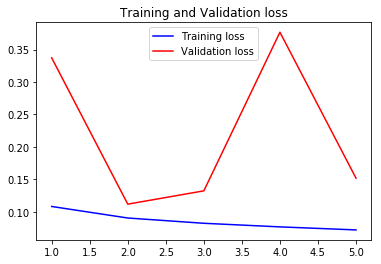

[INFO] Calculating model accuracy
896/896 [==============================] - 1s 2ms/step
Test Accuracy: 97.00691103935242


In [17]:
Res_Plot_Test_Save('Resnet_With_Imagenet_Weingts.h5')

### **VGG16 Model**

##### Weights : Imagenet

In [18]:
from keras.models import Model
from keras.applications import vgg16
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the Resnet model so we can do transfer learning
vgg = vgg16.VGG16(weights= None, include_top=False, input_shape= (128,128,3))
                             
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) 
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [19]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=5, verbose=1
    )

Epoch 1/5
111/111 [==============================] - 45s 407ms/step - loss: 0.0870 - accuracy: 0.9773 - val_loss: 0.1184 - val_accuracy: 0.9760
Epoch 2/5
111/111 [==============================] - 19s 168ms/step - loss: 0.0748 - accuracy: 0.9782 - val_loss: 0.1451 - val_accuracy: 0.9695
Epoch 3/5
111/111 [==============================] - 19s 169ms/step - loss: 0.0675 - accuracy: 0.9791 - val_loss: 0.3974 - val_accuracy: 0.9647
Epoch 4/5
111/111 [==============================] - 19s 168ms/step - loss: 0.0627 - accuracy: 0.9802 - val_loss: 0.0959 - val_accuracy: 0.9762
Epoch 5/5
111/111 [==============================] - 19s 169ms/step - loss: 0.0574 - accuracy: 0.9815 - val_loss: 0.0816 - val_accuracy: 0.9788


[INFO] Plotting model accuracy and Loss


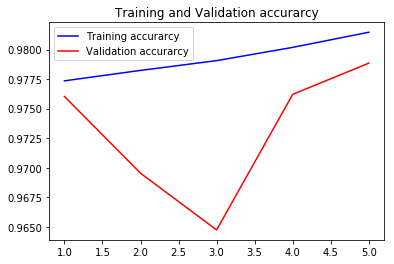

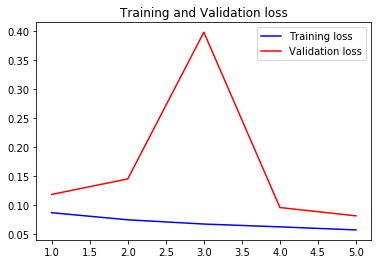

[INFO] Calculating model accuracy
896/896 [==============================] - 1s 2ms/step
Test Accuracy: 97.88454174995422


In [20]:
Res_Plot_Test_Save('VGG16_With_Imagenet_Weingts.h5')

### **VGG19 Model**

##### Weights : Imagenet

In [21]:
from keras.models import Model
from keras.applications import vgg19
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the Resnet model so we can do transfer learning
vgg = vgg19.VGG19(weights= None, include_top=False, input_shape= (128,128,3))
                             
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) 
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [22]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=2, verbose=1
    )

Epoch 1/2
111/111 [==============================] - 43s 384ms/step - loss: 0.0718 - accuracy: 0.9793 - val_loss: 0.0848 - val_accuracy: 0.9765
Epoch 2/2
111/111 [==============================] - 18s 167ms/step - loss: 0.0617 - accuracy: 0.9806 - val_loss: 0.0665 - val_accuracy: 0.9797


[INFO] Plotting model accuracy and Loss


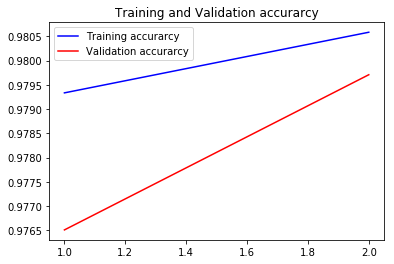

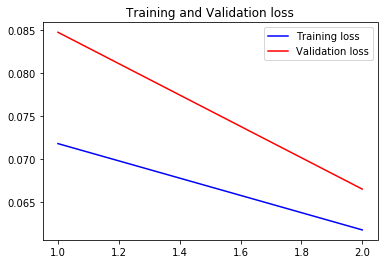

[INFO] Calculating model accuracy
896/896 [==============================] - 1s 2ms/step
Test Accuracy: 97.97077775001526


In [23]:
Res_Plot_Test_Save('VGG19_Imagenet.h5')

# Transfer Learning Challenges
Transfer learning has immense potential and is a commonly required enhancement for existing learning algorithms. Yet, there are certain pertinent issues related to transfer learning that need more research and exploration. Apart from the difficulty of answering the questions of what, when, and how to transfer, negative transfer and transfer bounds present major challenges.
* Negative Transfer: The cases we have discussed so far talk about improvements in target tasks based on knowledge transfer from the source task. There are cases when transfer learning can lead to a drop in performance. Negative transfer refers to scenarios where the transfer of knowledge from the source to the target does not lead to any improvement, but rather causes a drop in the overall performance of the target task. There can be various reasons for negative transfer, such as cases when the source task is not sufficiently related to the target task, or if the transfer method could not leverage the relationship between the source and target tasks very well. Avoiding negative transfer is very important and requires careful investigation. In their work, Rosenstien and their co-authors present empirically how brute-force transfer degrades performance in target tasks when the source and target are too dissimilar. Bayesian approaches by Bakker and their co-authors, along with other techniques exploring clustering-based solutions to identify relatedness, are being researched to avoid negative transfers.
* Transfer Bounds: Quantifying the transfer in transfer learning is also very important, that affects the quality of the transfer and its viability. To gauge the amount for the transfer, Hassan Mahmud and their co-authors used Kolmogorov complexity to prove certain theoretical bounds to analyze transfer learning and measure relatedness between tasks. Eaton and their co-authors presented a novel graph-based approach to measure knowledge transfer. Detailed discussions of these techniques are outside the scope of this article. Readers are encouraged to explore more on these topics using the publications outlined in this section!